# TP 4
Exemple de reconnaissance d'image

# Import des librairies et iniitalisation


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import torchvision
import matplotlib.pyplot as plt
#Affichage barre d'avancement
from tqdm.notebook import tqdm


In [2]:
#Taille de batch apprentissage et Inférence
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 1024 #

# Transforme l'image en tensor et normalise les couleurs
# Le résultats sera stocké dans le dossier "processed"
# https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize

image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets (prédéfini dans torchvision)

train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=image_transform)
# dataloaders (parcours intelligent des exemples)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

In [3]:
print(f"train : {len(train_dataset)} images.")
print(f"test : {len(test_dataset)} images.")

train : 60000 images.
test : 10000 images.


## Affichage d'images

torch.Size([1024, 1, 28, 28]) / torch.Size([1024])
Label: 7


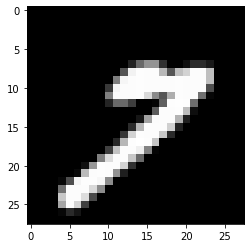

In [4]:
_, (example_datas, labels) = next(enumerate(test_loader))
print(example_datas.shape, '/',labels.shape)
# Affichage du premier exemple du batch
sample = example_datas[0][0]
# show the data
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0].item()))

##Création du modèle et de l'optimizer

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input channel 1, output channel 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        #input channel 10, output channel 20
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        #dropout layer
        self.conv2_drop = nn.Dropout2d()
        #fully connected layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
         return F.log_softmax(x,dim=1) # applique log à softmax pour pénaliser d'avantage les erreurs

In [6]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.5
# Choix cpu  ou gpu 
device = "cpu"
if torch.cuda.is_available():    
    device = "cuda"
    print('%d GPU(s) available' % torch.cuda.device_count())
model = CNN().to(device) 
# D'autres algorithmes de Gradient descent sont possibles
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) 
summary(model, (1, 28, 28))

1 GPU(s) available
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


## Fonctions d'apprentissage et de test

In [7]:
##Fonction d'apprentissage
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))


In [8]:
##Fonction de test
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # Fonction de coût
            pred = output.argmax(dim=1, keepdim=True) # Prédiction
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: coût : {:.4f}, Précision: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

##Apprentissage

In [9]:
num_epoch = 3
for epoch in range(1, num_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)



Test set: coût : 0.3258, Précision: 9029/10000 (90%)





Test set: coût : 0.2200, Précision: 9363/10000 (94%)





Test set: coût : 0.1727, Précision: 9502/10000 (95%)

